In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_solver import SpringRodsSystemSolver
from utils.computational_utils import l2_norm, approximate_in_positions

In [2]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular',
})

In [3]:
setup = {
    'interval': (-1, 1),
    'spring_len': 1,
    'material_const': (1, 1),
    'spring_const': (1, 1),
    'body_forces': lambda x: np.where(x < 0, 1, -1)
}

In [4]:
ref_quantization = 512
quantization_grid = [2, 4, 8, 16, 32, 64, 128, 256]

In [5]:
model = SpringRodsSystemSetup(
    **setup,
    step_size=1 / ref_quantization
)

solver = SpringRodsSystemSolver(model)

reference_solution = np.concatenate(solver())
reference_domain = np.concatenate((model.domain[0], model.domain[1]))

In [6]:
cmap = plt.cm.get_cmap('tab10', len(quantization_grid))

/tmp/ipykernel_10419/3690842560.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(quantization_grid))


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


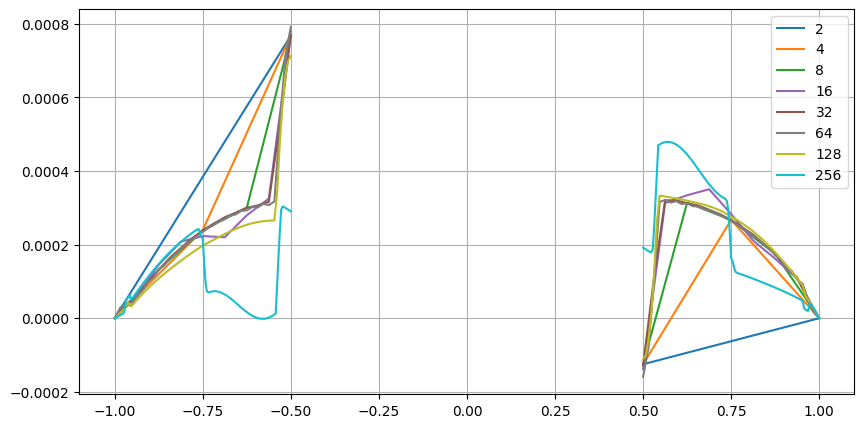

In [7]:
fig = plt.gcf()
fig.set_size_inches(10, 5)

error_norm = []

for idx, quantization in enumerate(tqdm(quantization_grid)):
    model = SpringRodsSystemSetup(
        **setup,
        step_size=1 / quantization
    )
    solver = SpringRodsSystemSolver(model)
    solution = np.concatenate(solver())

    curr_domain = np.concatenate((model.domain[0], model.domain[1]))
    err = solution - approximate_in_positions(reference_solution, reference_domain, curr_domain)
    left_rod_err = err[:model.domain[0].size]
    right_rod_err = err[model.domain[0].size:]

    error_norm.append(l2_norm(values=(left_rod_err, right_rod_err), domain=model.domain))

    plt.plot(model.domain[0], left_rod_err, color=cmap(idx), label=f'{quantization_grid[idx]}')
    plt.plot(model.domain[1], right_rod_err, color=cmap(idx))

plt.legend()

([<matplotlib.axis.YTick at 0x7f0ae9730a60>,
 [Text(0, 0.00022468458692160187, '2.25e-04'),
  Text(0, 0.00010827136696855734, '1.08e-04'),
  Text(0, 5.027564901824922e-05, '5.03e-05'),
  Text(0, 2.4475666377102772e-05, '2.45e-05'),
  Text(0, 8.539937618914226e-06, '8.54e-06'),
  Text(0, 3.833382001137016e-06, '3.83e-06'),
  Text(0, 1.361248337752036e-06, '1.36e-06'),
  Text(0, 5.618389963332793e-07, '5.62e-07')])

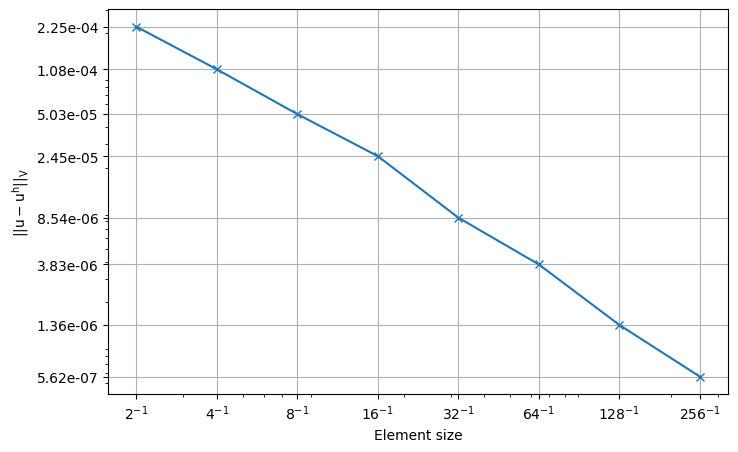

In [8]:
fig = plt.gcf()
fig.set_size_inches(8, 5)

plt.plot(quantization_grid, error_norm, marker='x')
plt.xlabel('Element size')
plt.ylabel('$||u - u^h||_V$')
plt.xscale('log')
plt.yscale('log')
# plt.xticks(quantization_grid, [f'$\\frac{{1}}{{{q}}}$' for q in quantization_grid], fontsize=16)
plt.xticks(quantization_grid, [f'${{{q}}}^{{-1}}$' for q in quantization_grid])
plt.yticks(error_norm, [f'{err:.2e}' for err in error_norm])